In [1]:
%cd '/Users/bryan/Downloads/Peking_U/GlobalLocal/'

/Users/bryan/Downloads/Peking_U/GlobalLocal


In [2]:
import scipy.io as sio
import mat4py
import os
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import time
import pickle
import h5py

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,LinearRegression
import sklearn
from sklearn.metrics.scorer import make_scorer

from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

/Users/bryan/anaconda3/lib/python3.7/site-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [3]:
# path = 'SEQ_pre_data/'
path = 'SIM_pre_data/'

In [4]:
sub_folder = sorted([i for i in os.listdir(path) if 'sub' in i])


In [5]:
folder = path+sub_folder[2]+'/'

In [6]:
file_path = folder + sorted(os.listdir(folder))[-1]

In [7]:
# # ## load all subjects' data
# # DATA = []
# # design = []
# for s in sub_folder[8:]:
#     folder = path+s+'/'
#     file_path = folder + sorted(os.listdir(folder))[-1]
#     tes = sio.loadmat(file_path)
#     if s == 'sub09':
#         data_tmp = (tes['data_clean_planar'][0,0][3]).copy()
#     else:
#         data_tmp = (tes['data_clean_planar'][0,0][2]).copy()
#     data = np.zeros(data_tmp[0].shape + data_tmp[0][0].shape)
#     for i in range(data_tmp.shape[-1]):
#         data[i,] = data_tmp[0][i].copy()
#     del data_tmp
#     DATA.append(data)
#     design.append(tes['task_code'])
# Time = tes['data_clean_planar'][0,0][3][0,0].copy().reshape(-1)


In [8]:
# meg_data = np.concatenate(DATA,axis=0)
# design_matrix = np.concatenate(design,axis=0)
# hf = h5py.File(path + 'all_data.hdf5', "w")
# hf.create_dataset('MEG_data',compression="gzip", compression_opts=9,data=meg_data)
# hf.create_dataset('design_matrix',compression="gzip",compression_opts=9, data=design_matrix)
# hf.create_dataset('time', data=Time,compression="gzip",compression_opts=9)
# hf.close()

In [7]:
with h5py.File(path + 'all_data.hdf5', 'r') as f:
    data = f.get('MEG_data')[:]
    design_matrix = f.get('design_matrix')[:]
    Time = f.get('time')[:]

## Statistics

In [10]:
#Task design table 

df = pd.DataFrame(design_matrix,columns = ['type','angle_1','angle_2',
                                              'digitize_1','digitize_2','Performance'])
display(df)

,type,angle_1,angle_2,digitize_1,digitize_2,Performance
0,1,80,0,5,1,1
1,1,40,0,3,1,-19
2,1,140,120,8,7,5
3,1,160,140,9,8,13
4,1,0,0,1,1,1
...,...,...,...,...,...,...
8180,2,40,100,3,6,-8
8181,2,0,20,1,2,-5
8182,1,40,160,3,9,3
8183,2,140,80,8,5,1


In [11]:
df.groupby('type')['Performance'].agg('mean')

type
1    0.026271
2    0.601620
Name: Performance, dtype: float64

#### sio.loadmat
```  
Data:
tes['data_clean_planar'][0,0]  
[0] : channel
[1] : label
[2] : signal
[3] : time
[4] : sample rate
[5] : 
    [0,0][0] trial id
    
 Task design   
 tes['task_code']
 
 column names:
 ['Global/local(1/2) Global orientation(angle)  Local orientation(angle)  Global orientation(1-9)
  Local orientation(1-9)  Performance difference']
 ```
 

## Decoding

In [8]:
label = design_matrix[:,0].reshape(-1)
ori_gb = design_matrix[:,3]
ori_lc = design_matrix[:,4]

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
###Remove global response(minus average):
ave_over_gl_ori = [np.average(data[design_matrix[:,3]==i],axis = 0)for i in range(1,9)] 
for i in range(1,9):
    data[design_matrix[:,3]==i] = data[design_matrix[:,3]==i] - ave_over_gl_ori[i-1]  

In [ ]:
X = data[label == 1]
y = ori_gb[label == 1]
clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs',
                                                         multi_class = 'auto',
                                                         random_state= 1,
                                                         max_iter=1000))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring= 'accuracy', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)
# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


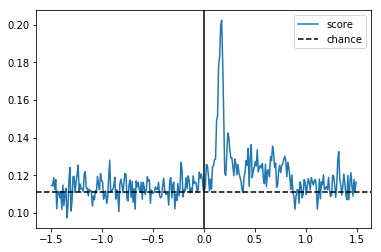

In [29]:
plt.plot(Time, score, label='score')
plt.axhline(1/len(np.unique(ori_gb)), color='k', linestyle='--', label='chance')
# plt.set_xlabel('Times')
# plt.set_ylabel('ACC')  # Area Under the Curve
plt.axvline(.0, color='k', linestyle='-')
plt.legend()

In [47]:
X = data[label == 2]
y = ori_lc[label == 2]
X = X[(y==2)|(y==5)|(y==8)]
y = y[(y==2)|(y==5)|(y==8)]

clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs',
                                                         multi_class = 'auto',
                                                         random_state= 1,
                                                         max_iter=1000))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring= 'accuracy', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)
# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)

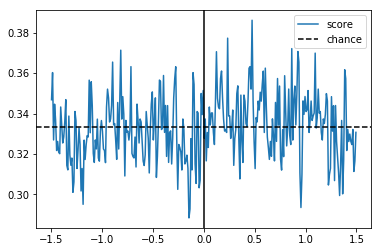

In [48]:
plt.plot(Time, score, label='score')
plt.axhline(1/len(np.unique(y)), color='k', linestyle='--', label='chance')
# plt.set_xlabel('Times')
# plt.set_ylabel('ACC')  # Area Under the Curve
plt.axvline(.0, color='k', linestyle='-')
plt.legend()

In [11]:
## select time of interest
tmin = 300
tmax = 700
data = data[:,:,(Time>tmin/1000)&(Time<tmax/1000)]

In [12]:
X = data[label == 2].reshape(-1,data.shape[1]*data.shape[2])
y = ori_lc[label == 2]

In [15]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# define the model
model = RandomForestClassifier()

# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.113 (0.001)
